<a href="https://colab.research.google.com/github/Omar-Aliii/AI-AGENT/blob/main/AI-AGENT/Text-To-Speech%20Models/T5_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Feb  1 10:53:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning==1.1.1
!pip install --quiet tokenizers
!pip install --quiet sentencepiece
!pip install termcolor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 669.7/669.7 kB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.1.1
    Uninstalling pytorch-lightning-1.1.1:
      Successfully uninstalled pytorch-lightning-1.1.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import argparse
import glob
import os

import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap
from keras.callbacks import ModelCheckpoint


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

In [ ]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [ ]:
def extract_questions_and_answers(factoid_path: Path):
    with factoid_path.open() as json_file:
        data = json.load(json_file)

    questions = data["data"][0]["paragraphs"]

    data_rows = []


    for question in questions:
        context = question["context"]
        for question_and_answers in question["qas"]:
            question = question_and_answers["question"]
            answers = question_and_answers["answers"]
            for answer in answers:
                answer_text = answer["text"]
                answer_start = answer["answer_start"]
                answer_end = answer_start + len(answer_text)

                data_rows.append({
                    "question": question,
                    "context": context,
                    "answer_text": answer_text,
                    "answer_start": answer_start,
                    "answer_end": answer_end
                })
    return pd.DataFrame(data_rows)

In [ ]:
factoid_paths = [sorted(list(Path("/content/drive/MyDrive/Dataset/").glob("BioASQ-train-*")))]
filtered_paths = [path for path in factoid_paths[0] if '4b' in str(path) or '5b' in str(path)]
filtered_paths

[PosixPath('/content/drive/MyDrive/Dataset/BioASQ-train-factoid-4b.json'),
 PosixPath('/content/drive/MyDrive/Dataset/BioASQ-train-factoid-5b.json')]

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datasets import load_dataset

squad_v2 = False  # Change this to True if you want to load SQuAD v2

# Determine dataset name based on squad_v2 variable
dataset_name = "squad_v2" if squad_v2 else "squad"

# Load the dataset
datasets = load_dataset(dataset_name)
# Extract the first 100 data points
first_100_data = datasets["train"][:5825]

# Convert the data to a DataFrame
df = pd.DataFrame(first_100_data)

# Filter out duplicate contexts
df_unique_contexts = df.drop_duplicates(subset='context')

# If there are fewer than 100 unique contexts, select the first 100 rows
if len(df_unique_contexts) < 100:
    df_unique_contexts = df_unique_contexts[:100]

# Display the DataFrame with unique contexts
df_unique_contexts

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ..."
5,5733bf84d058e614000b61be,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",When did the Scholastic Magazine of Notre dame...,"{'text': ['September 1876'], 'answer_start': [..."
10,5733bed24776f41900661188,University_of_Notre_Dame,The university is the major seat of the Congre...,Where is the headquarters of the Congregation ...,"{'text': ['Rome'], 'answer_start': [119]}"
15,5733a6424776f41900660f51,University_of_Notre_Dame,The College of Engineering was established in ...,How many BS level degrees are offered in the C...,"{'text': ['eight'], 'answer_start': [487]}"
20,5733a70c4776f41900660f64,University_of_Notre_Dame,All of Notre Dame's undergraduate students are...,What entity provides help with the management ...,"{'text': ['Learning Resource Center'], 'answer..."
...,...,...,...,...,...
5806,5734188e4776f41900661861,Portugal,The most important demographic influence in th...,In what group of people do the Portuguese have...,"{'text': ['Paleolithic peoples'], 'answer_star..."
5809,5734195bd058e614000b694a,Portugal,Portugal's colonial history has long since bee...,What is the cornerstone of Portugal's national...,"{'text': ['colonial history'], 'answer_start':..."
5814,57341a094776f41900661873,Portugal,"According to the 2011 Census, 81.0% of the Por...",What percentage of the Portuguese people are R...,"{'text': ['81.0%'], 'answer_start': [30]}"
5818,57341cfc4776f419006618a1,Portugal,"Many Portuguese holidays, festivals and tradit...",In what religion do many Portuguese holidays a...,"{'text': ['Christian'], 'answer_start': [58]}"


In [ ]:
dfs = []

for factoid_path in filtered_paths:
    dfs.append(extract_questions_and_answers(factoid_path))


df = pd.concat(dfs)

In [ ]:
df.head()

,question,context,answer_text,answer_start,answer_end
0,What is the inheritance pattern of Li–Fraumeni...,Balanced t(11;15)(q23;q15) in a TP53+/+ breast...,autosomal dominant,213,231
1,What is the inheritance pattern of Li–Fraumeni...,Genetic modeling of Li-Fraumeni syndrome in ze...,autosomal dominant,105,123
2,Which type of lung cancer is afatinib used for?,Clinical perspective of afatinib in non-small ...,EGFR-mutant NSCLC,1203,1220
3,Which hormone abnormalities are characteristic...,"DOCA sensitive pendrin expression in kidney, h...",thyroid,419,426
4,Which hormone abnormalities are characteristic...,Clinical and molecular characteristics of Pend...,thyroid,705,712


In [ ]:
# Extracting 'text' and 'answer_start' into separate arrays
text_array = [item['text'][0] for item in df_unique_contexts['answers']]
answer_start_array = [item['answer_start'][0] for item in df_unique_contexts['answers']]
contexts = df_unique_contexts['context'].values
questions = df_unique_contexts['question'].values
# Creating a new DataFrame with extracted arrays
new_data = {
    'question': questions,
    'context': contexts,
    'answer_text': text_array,
    'answer_start': answer_start_array
}

df_extracted = pd.DataFrame(new_data)



# Displaying the new DataFrame
df_extracted

,question,context,answer_text,answer_start
0,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",Saint Bernadette Soubirous,515
1,When did the Scholastic Magazine of Notre dame...,"As at most other universities, Notre Dame's st...",September 1876,248
2,Where is the headquarters of the Congregation ...,The university is the major seat of the Congre...,Rome,119
3,How many BS level degrees are offered in the C...,The College of Engineering was established in ...,eight,487
4,What entity provides help with the management ...,All of Notre Dame's undergraduate students are...,Learning Resource Center,496
...,...,...,...,...
995,In what group of people do the Portuguese have...,The most important demographic influence in th...,Paleolithic peoples,198
996,What is the cornerstone of Portugal's national...,Portugal's colonial history has long since bee...,colonial history,11
997,What percentage of the Portuguese people are R...,"According to the 2011 Census, 81.0% of the Por...",81.0%,30
998,In what religion do many Portuguese holidays a...,"Many Portuguese holidays, festivals and tradit...",Christian,58


In [ ]:
df = df.drop_duplicates(subset = ["question"]).reset_index(drop = True)

In [ ]:
MODEL_NAME = "t5-small"

In [ ]:
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
class BioQADataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        source_max_token_len: int = 396,
        target_max_token_len: int = 32
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.source_max_token_len = source_max_token_len
        self.target_max_token_len = target_max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        # Encode source (question and context)
        source_encoding = tokenizer(
            data_row["question"],
            data_row["context"],
            max_length=self.source_max_token_len,
            padding="max_length",
            truncation="only_second",
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        # Encode target (answer_text)
        target_encoding = tokenizer(
            data_row["answer_text"],
            max_length=self.target_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        # Prepare labels (setting padding tokens to -100)
        labels = target_encoding["input_ids"]
        labels[labels == 0] = -100

        return dict(
            question=data_row["question"],
            context=data_row["context"],
            answer_text=data_row["answer_text"],
            input_ids=source_encoding["input_ids"].flatten(),
            attention_mask=source_encoding["attention_mask"].flatten(),
            labels=labels.flatten()
        )


In [ ]:
sample_dataset = BioQADataset(df_extracted, tokenizer)

In [ ]:
train_df, val_df = train_test_split(df_extracted,test_size = 0.05)

In [ ]:
class BioQADataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size: int = 8,
        source_max_token_len: int = 396,
        target_max_token_len: int = 32
    ):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.source_max_token_len = source_max_token_len
        self.target_max_token_len = target_max_token_len

    def setup(self, stage=None):
        self.train_dataset = BioQADataset(
            self.train_df,
            self.tokenizer,
            self.source_max_token_len,
            self.target_max_token_len
        )

        self.test_dataset = BioQADataset(
            self.train_df,
            self.tokenizer,
            self.source_max_token_len,
            self.target_max_token_len
        )


    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle=True,
            num_workers = 4
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            num_workers = 4
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            num_workers = 4
        )

In [ ]:
BATCH_SIZE = 8
N_EPOCHS = 100

data_module = BioQADataModule(train_df, val_df, tokenizer, batch_size = BATCH_SIZE)
data_module.setup()

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict = True)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
class BioQAModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
        self.validation_step_outputs = []


    def forward(self, input_ids, attention_mask, labels=None):
        output = self.model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            labels=labels
            )

        return output.loss, output.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.validation_step_outputs.append(loss)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

    def on_validation_epoch_end(self):
        # Compute validation accuracy
         epoch_average = torch.stack(self.validation_step_outputs).mean()
         self.log("validation_epoch_average", epoch_average)
         self.validation_step_outputs.clear()  # free memory

In [ ]:
model = BioQAModel()

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger


# Assuming you have X_train, y_train, X_val, y_val defined

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',  # 'min' means training will stop when the quantity monitored has stopped decreasing
)


checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)
logger = TensorBoardLogger("training-logs", name = "bio-qa")
trainer = Trainer(
    callbacks=[checkpoint_callback, early_stopping],
    max_epochs=N_EPOCHS,
    accelerator="gpu",  # Use "gpu" for single GPU, "ddp" for distributed training
    logger=logger
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
%load_ext tensorboard

In [ ]:
!kill 10969

/bin/bash: line 1: kill: (10969) - No such process


In [ ]:
%tensorboard --logdir ./training-logs

In [ ]:
df_extracted.shape

(1000, 4)

In [ ]:
# prompt: remove training-logs file

!rm -rf training-logs


In [ ]:
trainer.fit(model,data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 119: 'val_loss' reached 0.31668 (best 0.31668), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 238: 'val_loss' reached 0.19539 (best 0.19539), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 357: 'val_loss' reached 0.13907 (best 0.13907), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 476: 'val_loss' reached 0.10717 (best 0.10717), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 595: 'val_loss' reached 0.08061 (best 0.08061), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 714: 'val_loss' reached 0.06197 (best 0.06197), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 833: 'val_loss' reached 0.04674 (best 0.04674), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 952: 'val_loss' reached 0.03366 (best 0.03366), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 1071: 'val_loss' reached 0.02927 (best 0.02927), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 1190: 'val_loss' reached 0.02026 (best 0.02026), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 1309: 'val_loss' reached 0.01744 (best 0.01744), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 1428: 'val_loss' reached 0.01405 (best 0.01405), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 1547: 'val_loss' reached 0.01078 (best 0.01078), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 1666: 'val_loss' reached 0.00862 (best 0.00862), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 1785: 'val_loss' reached 0.00640 (best 0.00640), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 1904: 'val_loss' reached 0.00489 (best 0.00489), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 2023: 'val_loss' reached 0.00449 (best 0.00449), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 2142: 'val_loss' reached 0.00297 (best 0.00297), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 2261: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 2380: 'val_loss' reached 0.00211 (best 0.00211), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 2499: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 2618: 'val_loss' reached 0.00158 (best 0.00158), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 2737: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 2856: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 2975: 'val_loss' reached 0.00156 (best 0.00156), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 3094: 'val_loss' reached 0.00124 (best 0.00124), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 3213: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 3332: 'val_loss' reached 0.00101 (best 0.00101), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 3451: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 3570: 'val_loss' reached 0.00100 (best 0.00100), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 3689: 'val_loss' reached 0.00097 (best 0.00097), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 3808: 'val_loss' reached 0.00071 (best 0.00071), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 3927: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 4046: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 4165: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 4284: 'val_loss' reached 0.00065 (best 0.00065), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 4403: 'val_loss' reached 0.00056 (best 0.00056), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 4522: 'val_loss' reached 0.00039 (best 0.00039), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 4641: 'val_loss' reached 0.00033 (best 0.00033), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 4760: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 4879: 'val_loss' reached 0.00028 (best 0.00028), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 4998: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 5117: 'val_loss' reached 0.00024 (best 0.00024), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 5236: 'val_loss' reached 0.00022 (best 0.00022), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 5355: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 5474: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 5593: 'val_loss' reached 0.00020 (best 0.00020), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 5712: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 5831: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 5950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 6069: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 6188: 'val_loss' was not in top 1


In [ ]:
trained_model = BioQAModel.load_from_checkpoint("/content/checkpoints/best-checkpoint.ckpt")
trained_model.freeze()

In [ ]:
def generate_answer(question):
    source_encoding = tokenizer(
        question["question"],
        question["context"],
        max_length=396,
        padding="max_length",
        truncation="only_second",
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    source_encoding = {key: value.to(trained_model.device) for key, value in source_encoding.items()}

    generated_ids = trained_model.model.generate(
        input_ids=source_encoding["input_ids"],
        attention_mask=source_encoding["attention_mask"],
        num_beams=1,
        max_length=80,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True,
        use_cache=True
    )

    preds = [
        tokenizer.decode(generated_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        for generated_id in generated_ids
    ]

    return "".join(preds)

In [ ]:
sample_question=df_extracted.iloc[1]
#sample_question['quesiton'] = "where diseaseeeee are small bowel lymphoma commonly associated with?"
question = sample_question['question']
answer = sample_question['answer_text']
#answer = "celiac disease"
#generated_answer = "ronaldo cardiomyopathy"
print(sample_question['question'])
print(sample_question['answer_text'])

When did the Scholastic Magazine of Notre dame begin publishing?
September 1876


In [ ]:
# prompt: generate answer for each sample question store them in gen_answers

gen_answers = []
for index, row in df_extracted.iterrows():
    question = row['question']
    context = row['context']

    generated_answer = generate_answer({"question": question, "context": context})
    gen_answers.append(generated_answer)


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


In [ ]:
# prompt: extract answer_text from df_extracted
ground_truth_answers = []
ground_truth_answers = (df_extracted['answer_text'].values)
ground_truth_answers

array(['Saint Bernadette Soubirous', 'September 1876', 'Rome', 'eight',
       'Learning Resource Center', '1924',
       'Joan B. Kroc Institute for International Peace Studies', '14',
       '3,577', '18th overall', 'Father Joseph Carrier, C.S.C.', '1882',
       'The Lobund Institute', 'The Review of Politics', 'John Jenkins',
       '8,448', '80%', 'Congregatio a Sancta Cruce', 'Washington Hall',
       'scholastic and classical', 'Knute Rockne',
       'the Protestant establishment', "Father John Francis O'Hara",
       'more than half', '1917–2015', 'coeducational', '1987–2005',
       '2005', 'Congregation of Holy Cross', 'Fr. Zahm', '29', '2008',
       '1968', 'The College of Arts and Letters', 'Father Patrick Dillon',
       'School of Architecture', '2015',
       'The rise of Hitler and other dictators',
       'University of Notre Dame du', 'its Fighting Irish football team',
       'among the top twenty', '1842', '1849', 'NDtv', '$215 million',
       'National Collegiate

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
#!pip install sentence_transformers scikit-learn
!pip install nltk
!pip install bert_score


In [ ]:
size_of_ground_truth_answers = len(ground_truth_answers)

# Print or use the size as needed
print("Size of ground_truth_answers:", size_of_ground_truth_answers)

Size of ground_truth_answers: 1000


In [ ]:
from nltk.tokenize import word_tokenize


import nltk
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from bert_score import score
from itertools import islice
reference = np.array(ground_truth_answers)
candidate = np.array(gen_answers)

Streaming output truncated to the last 5000 lines.
Sentence 1:
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000

Sentence 2:
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000

Sentence 3:
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000

Sentence 4:
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000

Sentence 5:
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000

Sentence 6:
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000

Sentence 7:
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000

Sentence 8:
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000

Sentence 9:
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000

Sentence 10:
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000

Sentence 11:
Precision: 0.882904
Recall: 0.846523
F1 score: 0.864331

Sentence 12:
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000

Sentence 13:
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000

Sentence 14:
Precision: 1.000000
Recall: 1.00000

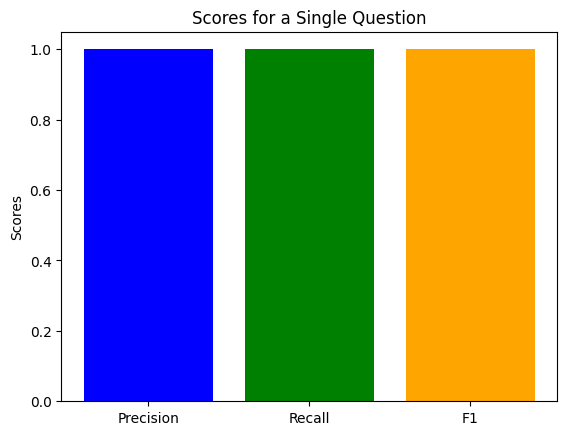

In [ ]:
precision_list = []
recall_list = []
f1_list = []

# Compute BERTScore directly from the filtered generated text and reference context
# Iterate through each pair of sentences and calculate scores
for ref, cand in zip(reference, candidate):
    P, R, F1 = score([ref], [cand], lang='en', model_type='bert-base-uncased', verbose=False)
    print(f"True answer: {ref}")
    print(f"Generated answer: {cand}")
    print(f"Precision: {P.mean().item()}")
    print(f"Recall: {R.mean().item()}")
    print(f"F1: {F1.mean().item()}\n")
    precision_list.append(P.mean().item())
    recall_list.append(R.mean().item())
    f1_list.append(F1.mean().item())

# Print the results
for i, (precision, recall, f1) in enumerate(zip(precision_list, recall_list, f1_list), 1):
    print(f'Sentence {i}:')
    print(f'Precision: {precision:.6f}')
    print(f'Recall: {recall:.6f}')
    print(f'F1 score: {f1:.6f}\n')

# Plot bar chart with colors
labels = ['Precision', 'Recall', 'F1']
scores = [precision_list[0], recall_list[0], f1_list[0]]
colors = ['blue', 'green', 'orange']




plt.bar(labels, scores, color=colors)
plt.ylabel('Scores')
plt.title('Scores for a Single Question')
plt.show()

In [ ]:
average_precision = sum(precision_list) / len(precision_list)
average_recall = sum(recall_list) / len(recall_list)
average_f1 = sum(f1_list) / len(f1_list)

# Print average scores
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1 Score: {average_f1:.4f}")

Average Precision: 0.9907
Average Recall: 0.9919
Average F1 Score: 0.9911


In [ ]:
print(sample_question)
generated_answer = generate_answer(sample_question)
print(generated_answer)


question        To whom did the Virgin Mary allegedly appear i...
context         Architecturally, the school has a Catholic cha...
answer_text                            Saint Bernadette Soubirous
answer_start                                                  515
Name: 0, dtype: object
Saint Bernadette Soubirous


# Future code

# Dr stuff

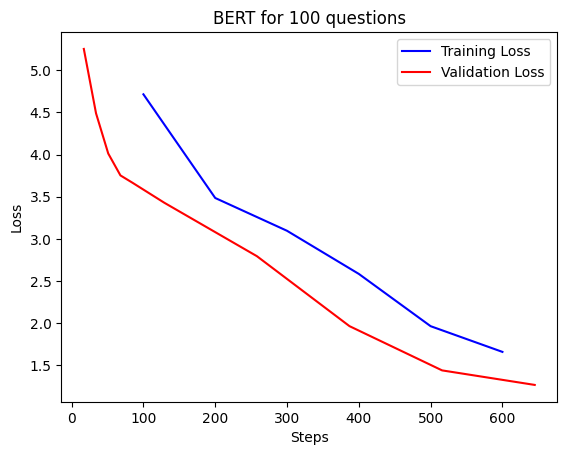

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data from CSV file
df_train = pd.read_csv('/content/drive/MyDrive/bert train_scalars.csv', skiprows=1, names=['Wall time', 'Step', 'Value'])
df_val = pd.read_csv('/content/drive/MyDrive/bert eval_scalars.csv', skiprows=1, names=['Wall time', 'Step', 'Value'])

# Plotting
plt.plot(df_train['Step'], df_train['Value'], label='Training Loss', color='blue')
plt.plot(df_val['Step'], df_val['Value'], label='Validation Loss', color='red')

# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('BERT for 100 questions')

# Add legend
plt.legend()

# Show the plot
plt.show()


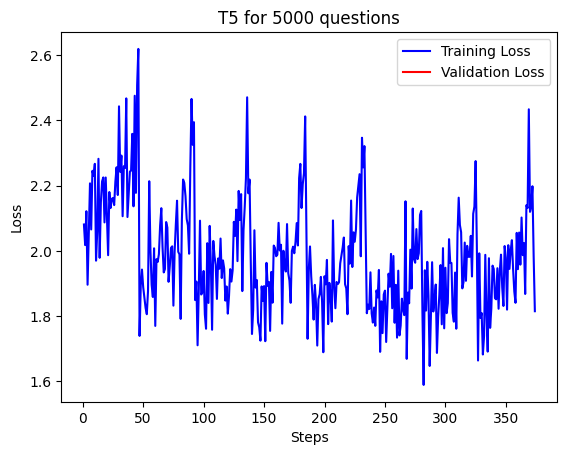

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data from CSV files
df_train = pd.read_csv('/content/drive/MyDrive/llamatrainloss5000.csv', skiprows=1, names=['Wall time', 'Step', 'Training Loss'])
df_val = pd.read_csv('/content/drive/MyDrive/llamaevalloss5000.csv', skiprows=1, names=['Wall time', 'Step', 'Validation Loss'])

# Merge dataframes on the 'Step' column
df_merged = pd.merge(df_train, df_val, on='Step', how='outer', suffixes=('_train', '_val'))

# Plotting
plt.plot(df_merged['Step'], df_merged['Training Loss'], label='Training Loss', color='blue')
plt.plot(df_merged['Step'], df_merged['Validation Loss'], label='Validation Loss', color='red')

# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('T5 for 5000 questions')

# Add legend
plt.legend()

# Show the plot
plt.show()

